In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from datetime import datetime
import yfinance as yf

# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Fetch the stock data
company_data = {}

for stock in tech_list:
    company_data[stock] = yf.download(stock, start=start, end=end,actions=False)

# Add company name to each DataFrame and concatenate into a single DataFrame
company_list = [company_data[stock] for stock in tech_list]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for df, name in zip(company_list, company_name):
    df["company_name"] = name

df = pd.concat(company_list, axis=0)
print(df.tail(10))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-07-25  182.910004  183.899994  176.800003  179.850006  179.850006   
2024-07-26  180.389999  183.190002  180.240005  182.500000  182.500000   
2024-07-29  183.839996  184.750000  182.380005  183.199997  183.199997   
2024-07-30  184.720001  185.860001  179.380005  181.710007  181.710007   
2024-07-31  185.050003  187.940002  184.460007  186.979996  186.979996   
2024-08-01  189.289993  190.600006  181.869995  184.070007  184.070007   
2024-08-02  166.750000  168.770004  160.550003  167.899994  167.899994   
2024-08-05  154.210007  162.960007  151.610001  161.020004  161.020004   
2024-08-06  161.710007  165.080002  158.539993  161.929993  161.929993   
2024-08-07  166.550003  167.580002  161.429993  162.770004  162.770004   

               Volume company_name  
Date                                
2024-07-25   44464200       AMAZON  


In [2]:
# Describe the dataset statistically 
print(company_data['AAPL'].describe())

             Open        High         Low       Close   Adj Close  \
count  253.000000  253.000000  253.000000  253.000000  253.000000   
mean   187.320830  189.058459  185.711462  187.438459  187.067722   
std     16.160574   16.453794   15.758046   16.115615   16.262981   
min    165.350006  166.399994  164.080002  165.000000  164.776505   
25%    175.309998  177.080002  173.740005  175.460007  174.802902   
50%    183.919998  185.149994  182.130005  184.149994  183.765930   
75%    193.110001  194.660004  191.940002  193.149994  192.672485   
max    236.479996  237.229996  233.089996  234.820007  234.820007   

             Volume  
count  2.530000e+02  
mean   6.084647e+07  
std    2.473514e+07  
min    2.404830e+07  
25%    4.747140e+07  
50%    5.431890e+07  
75%    6.613340e+07  
max    2.464214e+08  


In [3]:
# Describe concisely the features,
# including the number of non-null values and data types
print(company_data['AAPL'].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-08-07 to 2024-08-07
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          253 non-null    float64
 1   High          253 non-null    float64
 2   Low           253 non-null    float64
 3   Close         253 non-null    float64
 4   Adj Close     253 non-null    float64
 5   Volume        253 non-null    int64  
 6   company_name  253 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB
None


In [4]:
# Displaying rows and columns for the complete dataset
print("Dimensions of the Data:", df.shape)

Dimensions of the Data: (1012, 7)


In [5]:
# Displaying rows and columns for Apple
print("Dimensions of the Data:", company_data['AAPL'].shape)

Dimensions of the Data: (253, 7)


In [6]:
# Displaying rows and columns for Google
print(company_data['GOOG'].info())

# Describe concisely the features,
# including the number of non-null values and data types for Google 
print("Dimensions of the Data:", company_data['GOOG'].shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-08-07 to 2024-08-07
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          253 non-null    float64
 1   High          253 non-null    float64
 2   Low           253 non-null    float64
 3   Close         253 non-null    float64
 4   Adj Close     253 non-null    float64
 5   Volume        253 non-null    int64  
 6   company_name  253 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB
None
Dimensions of the Data: (253, 7)


In [7]:
# Data Cleaning 
# Handling Missing Values 

# Checking and printing for Missing Values (NaN) in the datasets
print("Are there any missing points in the dataset?:", df.isnull().values.any(), "\n")

Are there any missing points in the dataset?: False 



In [8]:
# Handling Duplicate Values:
# Checking and printing for duplicated rows in the DataFrame
print("Number of Duplicated Rows:", df.duplicated().sum(), "\n")

Number of Duplicated Rows: 0 



In [9]:
# No need to remove duplicated and recheck 
# for dimensions because there are no duplicate

In [10]:
from sklearn.model_selection import train_test_split
data = company_data['AAPL']
#data = df 
# Prepare features and target
data['Target'] = data['Close'].shift(-1)  # Predict next day's price
data = data.dropna()
X = data[['Close']]
y = data['Target']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Verify the sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 151
Validation set size: 50
Test set size: 51


<Axes: >

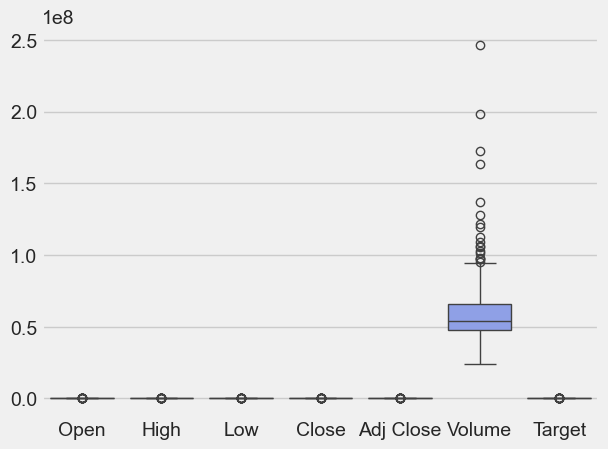

In [11]:
import seaborn as sns
sns.boxplot(data)

In [12]:
from scipy import stats

# Example DataFrame
data = df

# Ensure the data is numeric
numeric_data = data.select_dtypes(include=[np.number])

# Calculate z-scores
z_scores = stats.zscore(numeric_data)

# Identify outliers
outliers = (np.abs(z_scores) > 3)
            
# Print outliers
print("Outlier rows (True indicates an outlier):")
print(outliers)

Outlier rows (True indicates an outlier):
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2023-08-07  False  False  False  False      False   False
2023-08-08  False  False  False  False      False   False
2023-08-09  False  False  False  False      False   False
2023-08-10  False  False  False  False      False   False
2023-08-11  False  False  False  False      False   False
...           ...    ...    ...    ...        ...     ...
2024-08-01  False  False  False  False      False   False
2024-08-02  False  False  False  False      False    True
2024-08-05  False  False  False  False      False   False
2024-08-06  False  False  False  False      False   False
2024-08-07  False  False  False  False      False   False

[1012 rows x 6 columns]


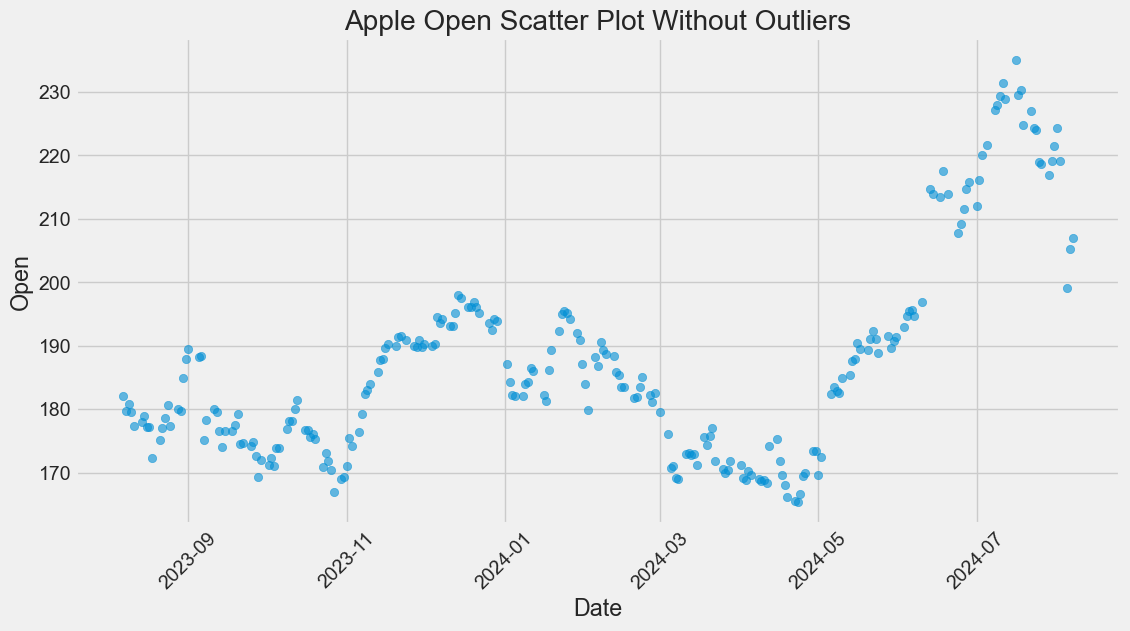

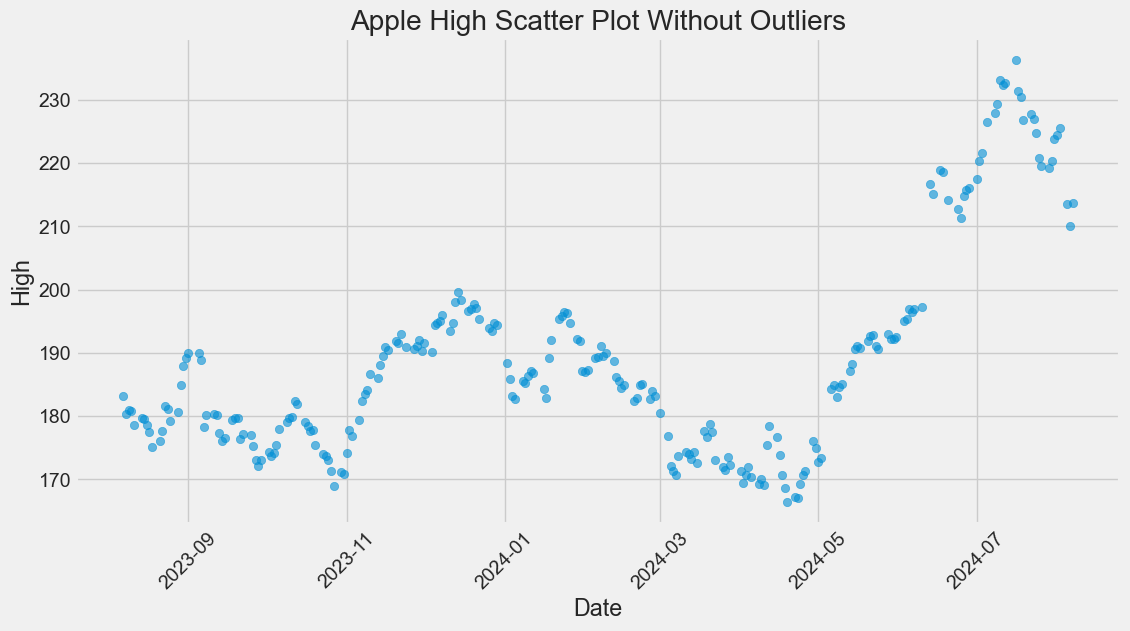

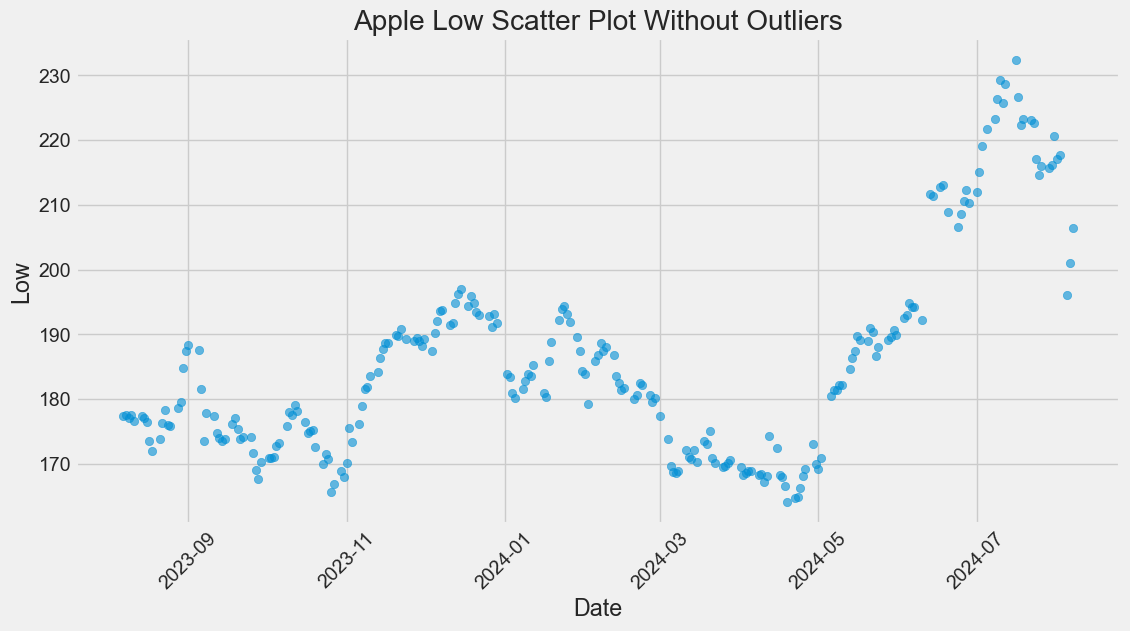

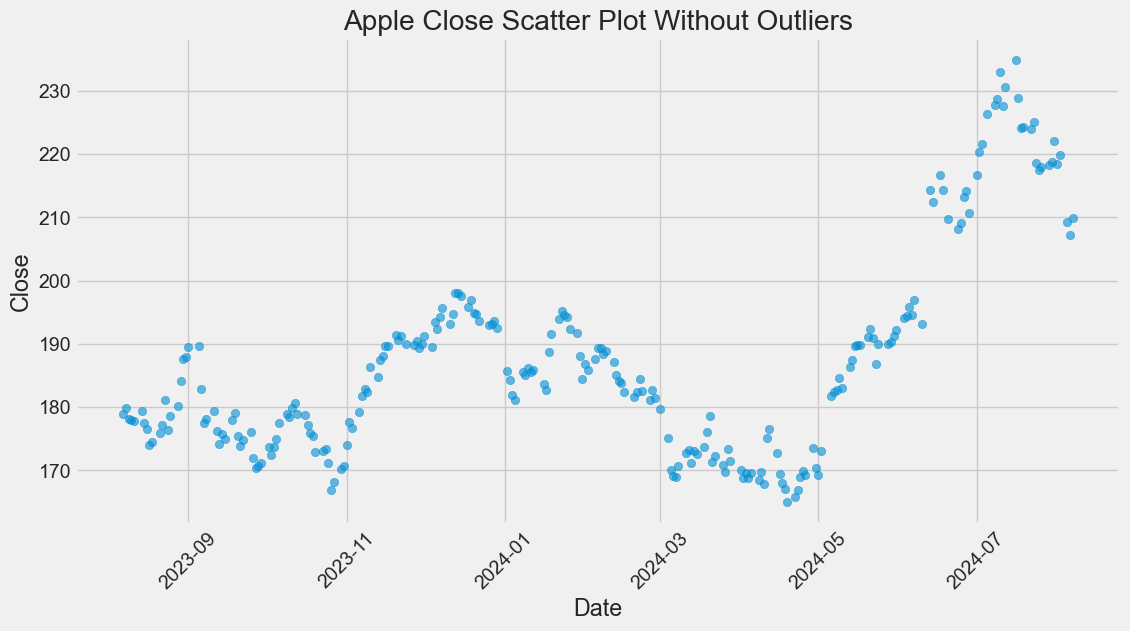

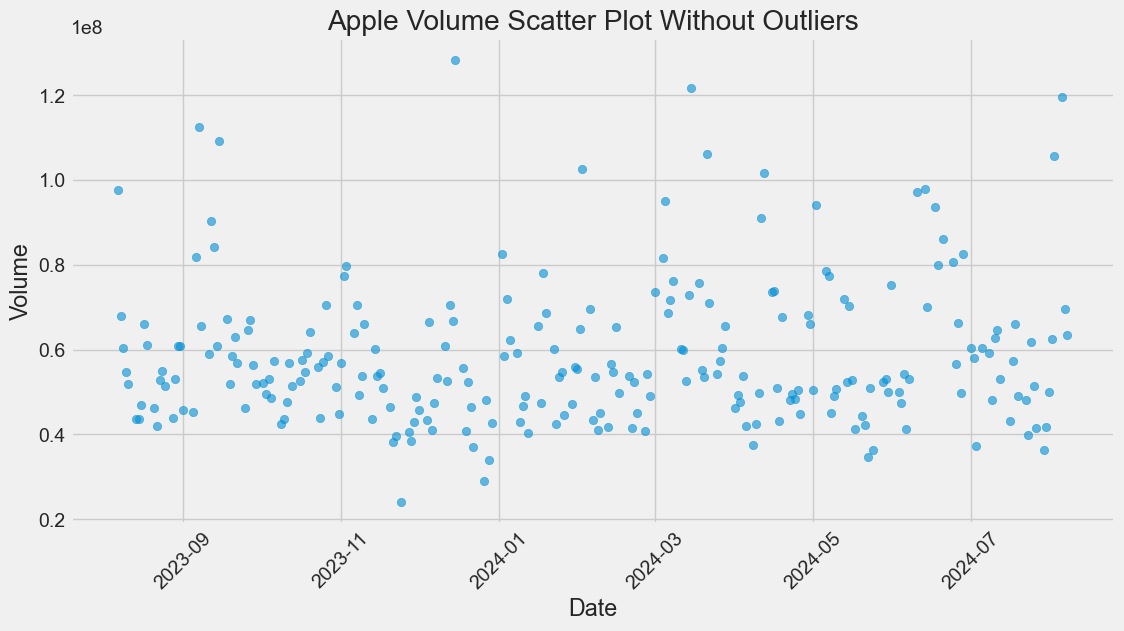

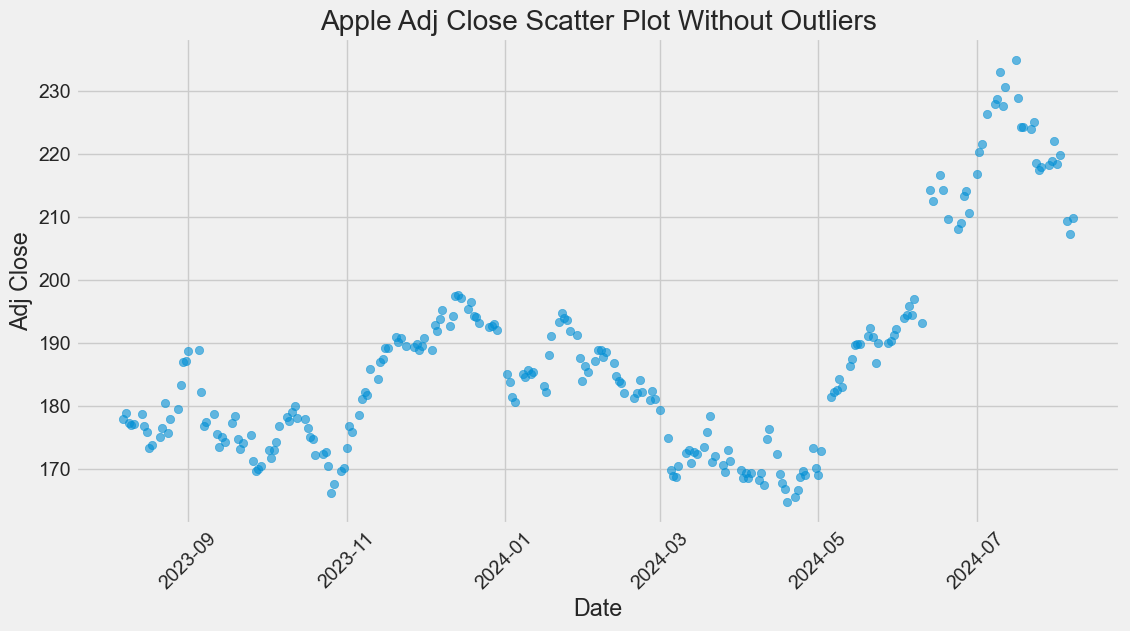

In [13]:
data = company_data['AAPL']
columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
data = data[columns_to_keep]

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

#handle outliers with a method
def remove_outliers(df):
    z_scores = stats.zscore(df.select_dtypes(include=[np.number]))
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]

#use the method for the company
data_cleaned=remove_outliers(data)

numerical_columns = data_cleaned.select_dtypes(include=[np.number]).columns

#show the results
for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(data_cleaned.index, data_cleaned[column], alpha=0.6)
    plt.title(f'Apple {column} Scatter Plot Without Outliers')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.show()
#print(data_cleaned.tail(10))